#### Performance Summary:
* Both clustering methods are garbage;
* Hungarian clustering performs slightly better than k-medoid (and is also less intensive)

## De Novo Extraction of Signatures (SigProfilerExtractor sad knock-off)
0. Split data into high and low mutational burden
1. Make Matrix M (SBS-96)
2. NMF (loop 100+ times for each k value 1-25)
- M is Poisson resampled, normalized
- initialize NNDSVD (Non-negative double singular value decomposition)
- Minimize objective function based on KL-Divergence; Lee-Sung multiplicative update       
- Hungarian algorithm for clustering (centroids are S matrix), or k-medoid
- Reconstruction: Find average distance to original M by reconstructing A with non-negative least squares
- Stability: silhouette scores
- Plot both^ and find appropriate k
3. Compare Peformance to SigProfilerExtractor
4.  Assess De Novo Signatures match to COSMIC

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyfaidx import Fasta
from sklearn.decomposition import NMF

from scipy.optimize import linear_sum_assignment
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import silhouette_score
from scipy.optimize import nnls

from tqdm import tqdm

## 1. Create M

#### load & preprocess

In [48]:
df = pd.read_csv("TCGA.STAD.mutations.txt", sep='\t', dtype=str)

# Remove hypermutators (top 1%)
# mut_counts = df['patient_id'].value_counts()
# cutoff = mut_counts.quantile(0.99)
# keep_samples = mut_counts[mut_counts < cutoff].index
# df = df[df['patient_id'].isin(keep_samples)]

# # remove genes with less than 10 mutations
# gene_counts = df['Hugo_Symbol'].value_counts()
# keep_genes= gene_counts[gene_counts > 10].index
# df = df[df['Hugo_Symbol'].isin(keep_genes)]

# Keep SNP only
df = df[df['Variant_Type'] == "SNP"]

df = df[['patient_id', 'Chromosome', 'Start_Position', 'Reference_Allele',
         'Tumor_Seq_Allele2', 'STRAND', 'CONTEXT']]

#### Split into high and low - Ambika's method/code

Log10 split: 2.822
Exact split: 664 mutations


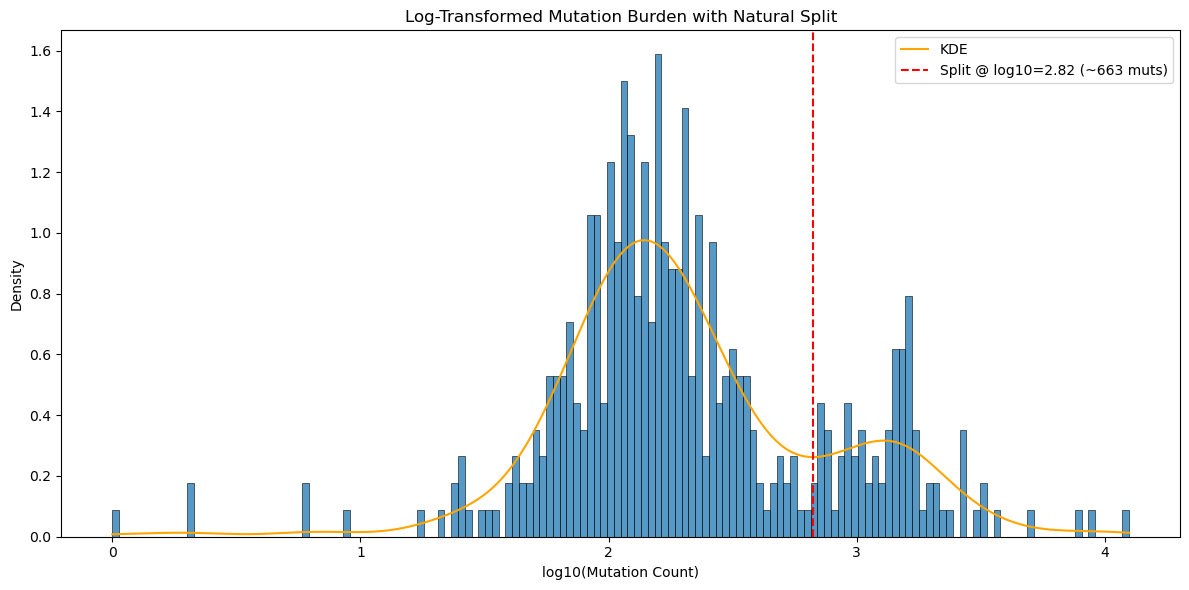

Adjusted split (previous bin edge): 612 mutations


In [49]:
import seaborn as sns
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks

mutation_counts = df['patient_id'].value_counts().sort_index()

# Get mutation counts > 0
counts_array = mutation_counts[mutation_counts > 0].values.astype(float)
log_counts = np.log10(counts_array)

# KDE
kde = gaussian_kde(log_counts)
x_vals = np.linspace(log_counts.min(), log_counts.max(), 1000)
kde_vals = kde(x_vals)

# Restrict search to real bimodal region (log10 ≈ 1.5 to 3.5)
mask = (x_vals > 1.5) & (x_vals < 3.5)
x_zoom = x_vals[mask]
kde_zoom = kde_vals[mask]

# Find trough (local minimum)
troughs, _ = find_peaks(-kde_zoom)
if len(troughs) > 0:
    log_split = x_zoom[troughs[0]]
    exact_split = 10**log_split
    print(f"Log10 split: {log_split:.3f}")
    print(f"Exact split: {exact_split:.0f} mutations")
else:
    log_split = None
    print("No trough found.")

# Plot
plt.figure(figsize=(12, 6))
sns.histplot(log_counts, bins=150, kde=False, stat="density")
plt.plot(x_vals, kde_vals, color='orange', label='KDE')

# Plot vertical line for the split
if log_split:
    plt.axvline(log_split, color='red', linestyle='--', label=f"Split @ log10={log_split:.2f} (~{int(exact_split)} muts)")

plt.xlabel("log10(Mutation Count)")
plt.ylabel("Density")
plt.title("Log-Transformed Mutation Burden with Natural Split")
plt.legend()
plt.tight_layout()
plt.show()

# Get histogram bin edges from the KDE-aligned plot
hist_bins = np.histogram_bin_edges(log_counts, bins=50)

# Convert log bins to linear mutation counts
linear_bins = 10 ** hist_bins

# Find the largest bin edge that is still less than the exact split
bin_aligned_split = linear_bins[linear_bins < exact_split].max()

print(f"Adjusted split (previous bin edge): {bin_aligned_split:.0f} mutations")

# Threshold based on natural split
threshold = 663  # or use int(exact_split) from your earlier KDE step

# Create mutation count dataframe
mutation_counts = df['patient_id'].value_counts().sort_index()
mutation_split_df = mutation_counts.to_frame(name="mutation_count")

# Assign groups
mutation_split_df["mutation_group"] = mutation_split_df["mutation_count"].apply(
    lambda x: "High" if x >= threshold else "Low"
)

# Split into patient ID lists
low_patients = mutation_split_df[mutation_split_df["mutation_group"] == "Low"].index.tolist()
high_patients = mutation_split_df[mutation_split_df["mutation_group"] == "High"].index.tolist()

# Filter original mutation rows
low_mut_filt = df[df['patient_id'].isin(low_patients)]
high_mut_filt = df[df['patient_id'].isin(high_patients)]

#### get tri-nucleotide context - Abid's method/code

In [50]:
# Build mutation matrix
def build_mutation_matrix(df, context_col="CONTEXT", sample_col="patient_id"):
    mutation_matrix = (
        df.groupby([sample_col, context_col])
        .size()
        .unstack(fill_value=0)
        .sort_index()
    )
    return mutation_matrix

# Create the matrices
#low_matrix = build_mutation_matrix(low_mut)
#high_matrix = build_mutation_matrix(high_mut)

def reverse_complement(seq):
    comp_dict = {"A": "T", "C": "G", "T": "A", "G": "C"}
    seq_rev = seq[::-1]
    seq_rev_comp = ""
    for letter in seq_rev:
        seq_rev_comp += comp_dict[letter]
    return seq_rev_comp

def standardize_to_pyrimidine(context_ref, context_mut):
    center_base = context_ref[1]
    if center_base in ['A', 'G']:
        comp_dict = {"A": "T", "C": "G", "T": "A", "G": "C"}
        rev_comp_ref = "".join([comp_dict[base] for base in context_ref[::-1]])
        rev_comp_mut = "".join([comp_dict[base] for base in context_mut[::-1]])
        return rev_comp_ref, rev_comp_mut
    else:
        return context_ref, context_mut

# low_mut_filt = low_mut[low_mut.Variant_Type == "SNP"]
# high_mut_filt = high_mut[high_mut.Variant_Type == "SNP"]

low_mut_filt["context_corrected"] = low_mut_filt.apply(
    lambda row: reverse_complement(row["CONTEXT"]) if row["STRAND"] == -1 else row["CONTEXT"],
    axis=1
)
high_mut_filt["context_corrected"] = high_mut_filt.apply(
    lambda row: reverse_complement(row["CONTEXT"]) if row["STRAND"] == -1 else row["CONTEXT"],
    axis=1
)

low_mut_filt["mut_corrected"] = low_mut_filt.apply(
    lambda row: reverse_complement(row["Tumor_Seq_Allele2"]) if row["STRAND"] == -1 else row["Tumor_Seq_Allele2"],
    axis=1
)
high_mut_filt["mut_corrected"] = high_mut_filt.apply(
    lambda row: reverse_complement(row["Tumor_Seq_Allele2"]) if row["STRAND"] == -1 else row["Tumor_Seq_Allele2"],
    axis=1
)

high_mut_filt["context_tri_ref"] = high_mut_filt["context_corrected"].apply(lambda x: x[(len(x)-3)//2:(len(x)-3)//2+3])
low_mut_filt["context_tri_ref"] = low_mut_filt["context_corrected"].apply(lambda x: x[(len(x)-3)//2:(len(x)-3)//2+3])

low_mut_filt["context_tri_mut"] = low_mut_filt["context_tri_ref"].str[0] + low_mut_filt["mut_corrected"].str[0] + low_mut_filt["context_tri_ref"].str[2]
high_mut_filt["context_tri_mut"] = high_mut_filt["context_tri_ref"].str[0] + high_mut_filt["mut_corrected"].str[0] + high_mut_filt["context_tri_ref"].str[2]

low_mut_filt[['std_context_tri_ref', 'std_context_tri_mut']] = low_mut_filt.apply(
    lambda row: standardize_to_pyrimidine(row['context_tri_ref'], row['context_tri_mut']), 
    axis=1, result_type='expand'
)
low_mut_filt["context_full_std"] = low_mut_filt["std_context_tri_ref"] + ">" + low_mut_filt["std_context_tri_mut"]

high_mut_filt[['std_context_tri_ref', 'std_context_tri_mut']] = high_mut_filt.apply(
    lambda row: standardize_to_pyrimidine(row['context_tri_ref'], row['context_tri_mut']), 
    axis=1, result_type='expand'
)
high_mut_filt["context_full_std"] = high_mut_filt["std_context_tri_ref"] + ">" + high_mut_filt["std_context_tri_mut"]

In [51]:
low_matrix = build_mutation_matrix(low_mut_filt, context_col = "context_full_std")
high_matrix = build_mutation_matrix(high_mut_filt, context_col = "context_full_std")

# Align both series to same context index
all_contexts = sorted(set(low_matrix.columns).union(set(high_matrix.columns)))

low_align = low_matrix.reindex(columns=all_contexts, fill_value=0)
high_align = high_matrix.reindex(columns=all_contexts, fill_value=0)

M_low = low_mut.T
M_high = high_mut.T

In [52]:
M_high

patient_id,TCGA-B7-5816,TCGA-B7-A5TI,TCGA-BR-4201,TCGA-BR-4256,TCGA-BR-4257,TCGA-BR-4280,TCGA-BR-4292,TCGA-BR-4361,TCGA-BR-4362,TCGA-BR-4368,...,TCGA-VQ-A8P2,TCGA-VQ-A8PB,TCGA-VQ-A8PO,TCGA-VQ-A8PP,TCGA-VQ-A8PX,TCGA-VQ-A91D,TCGA-VQ-A91E,TCGA-VQ-A91K,TCGA-VQ-A924,TCGA-VQ-AA6D
context_full_std,,,,,,,,,,,,,,,,,,,,,
ACA>AAA,3,1,1,2,1,0,2,4,4,5,...,3,3,0,0,0,2,1,8,2,2
ACA>AGA,5,1,2,2,1,1,3,7,1,0,...,8,1,0,0,0,1,0,3,1,2
ACA>ATA,14,3,42,20,22,4,20,40,17,30,...,149,27,13,25,7,23,10,16,23,7
ACC>AAC,5,0,4,1,3,0,3,5,1,0,...,27,1,3,2,3,4,3,6,2,0
ACC>AGC,0,1,2,2,2,2,0,6,0,0,...,1,1,3,3,0,2,0,4,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTG>TCG,19,8,21,15,16,11,14,65,15,10,...,46,6,14,18,8,18,9,16,10,4
TTG>TGG,2,0,1,0,1,0,0,1,1,1,...,1,1,0,4,0,3,0,1,1,3
TTT>TAT,1,1,1,1,2,1,2,1,2,1,...,4,1,1,0,1,1,1,1,3,0


### Previous way to derive mutation matrix with human genome FASTA reference file - commented out

In [4]:
# genome = Fasta("hg19.fa")

# ### Get Trinucleotide context
# def get_context(chrom, pos):
#     # Adjust for 0-based indexing in pyfaidx
#     seq = genome[chrom][pos-2:pos+1].seq.upper()
#     return seq

# def sbs_category(row):
#     ref = row['Reference_Allele']
#     alt = row['Tumor_Seq_Allele2']
#     chrom = row['Chromosome']
#     chrom = f"chr{chrom}"
#     pos = int(row['Start_Position'])
    
#     try:
#         context = get_context(chrom, pos)
#     except:
#         return None

#     # Normalize to C/T as reference
#     if ref in ['A', 'G']:
#         # Reverse complement
#         ref = rev_comp(ref)
#         alt = rev_comp(alt)
#         context = rev_comp(context)
    
#     return f"{context[0]}[{ref}>{alt}]{context[2]}"

# def rev_comp(base):
#     comp = {'A':'T','T':'A','G':'C','C':'G'}
#     return ''.join(comp[b] for b in reversed(base))


#### LOW

In [5]:
# low_mut['SBS96'] = low_mut.apply(sbs_category, axis=1)
# low_mut = low_mut.dropna(subset=['SBS96'])

# ## Convert to SBS-96 notation
# sbs96_types = sorted(set(low_mut['SBS96']))
# samples = sorted(set(low_mut['patient_id']))

# M_low = pd.DataFrame(0, index=sbs96_types, columns=samples)

# for _, row in low_mut.iterrows():
#     M_low.loc[row['SBS96'], row['patient_id']] += 1

# M_low.shape[1]

# ## M is a pd df that has 96 rows and N (samples) columns

/var/folders/jm/5vzzqzhj11sf3b5cll9hy6r80000gn/T/ipykernel_7070/1032197666.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_mut['SBS96'] = low_mut.apply(sbs_category, axis=1)


332

#### HIGH

In [6]:
# high_mut['SBS96'] = high_mut.apply(sbs_category, axis=1)
# high_mut = high_mut.dropna(subset=['SBS96'])

# ## Convert to SBS-96 notation
# sbs96_types = sorted(set(high_mut['SBS96']))
# samples = sorted(set(high_mut['patient_id']))

# M_high = pd.DataFrame(0, index=sbs96_types, columns=samples)

# for _, row in high_mut.iterrows():
#     M_high.loc[row['SBS96'], row['patient_id']] += 1


# M_high.shape[1]

/var/folders/jm/5vzzqzhj11sf3b5cll9hy6r80000gn/T/ipykernel_7070/540394065.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_mut['SBS96'] = high_mut.apply(sbs_category, axis=1)


83

In [7]:
M_low

,TCGA-3M-AB46,TCGA-3M-AB47,TCGA-B7-5818,TCGA-B7-A5TJ,TCGA-B7-A5TK,TCGA-B7-A5TN,TCGA-BR-4187,TCGA-BR-4191,TCGA-BR-4253,TCGA-BR-4255,...,TCGA-VQ-AA69,TCGA-VQ-AA6A,TCGA-VQ-AA6B,TCGA-VQ-AA6F,TCGA-VQ-AA6G,TCGA-VQ-AA6I,TCGA-VQ-AA6J,TCGA-VQ-AA6K,TCGA-ZA-A8F6,TCGA-ZQ-A9CR
A[C>A]A,2,2,2,1,1,1,1,2,0,0,...,1,1,2,1,0,1,2,0,0,2
A[C>A]C,2,2,2,4,1,0,0,4,1,1,...,1,1,0,1,0,0,0,1,0,5
A[C>A]G,0,1,0,1,0,0,0,1,0,0,...,0,0,0,0,2,0,0,0,0,0
A[C>A]T,1,2,2,0,1,2,0,3,0,0,...,0,2,0,0,1,0,3,2,0,0
A[C>G]A,3,0,1,0,0,2,0,0,0,0,...,0,1,0,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T[T>C]T,0,0,2,2,1,0,0,1,1,2,...,0,1,0,3,4,0,1,1,0,2
T[T>G]A,1,2,4,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
T[T>G]C,0,1,11,1,0,0,0,2,1,0,...,0,0,1,1,0,0,0,0,1,1
T[T>G]G,0,0,4,0,0,2,0,3,2,0,...,0,1,1,1,0,2,2,0,0,1


## 2. Create functions for:
- Poisson resampling, normalizing 
- running & repeating nmf (NNDSVD initialization, KL-divergence Lee-Sung multiplicative update)
- clustering (Hungarian algorithm)
- silhouette & reconstruction calculations

#### Can edit any of these base functions for different normalization, clustering, reconstructing M etc.

In [8]:
def poisson_resample(M):
    return np.random.poisson(lam=M)

def normalize_columns(M):
    # old normalization
    # M_norm = M / (M.sum(axis=0, keepdims=True) + 1e-9)

    # log2 normalization (as described by paper)
    M = np.asarray(M)
    M_norm = M.copy()
    col_sums = M.sum(axis=0)
    log2_sums = np.log2(col_sums + 1e-9)  # prevent log(0)
    factors = log2_sums / (col_sums + 1e-9)
    M_norm = M * factors  # broadcasts per column

    return M_norm

def run_kl_nmf(M, k, max_iter):
    model = NMF(n_components=k,
                init='nndsvd',
                solver='mu',
                beta_loss='kullback-leibler',
                max_iter=max_iter,
                random_state=None)
    W = model.fit_transform(M)
    H = model.components_
    loss = model.reconstruction_err_
    return W, H, loss

def repeated_kl_nmf(M, k, n_runs, nmf_iter):
    W_list, H_list, loss_list = [], [], []
    for _ in range(n_runs):
        M_poisson = poisson_resample(M)
        M_norm = normalize_columns(M_poisson)
        try:
            W, H, loss = run_kl_nmf(M_norm, k, nmf_iter)
            W_list.append(W)
            H_list.append(H)
            loss_list.append(loss)
        except:
            continue  # catch factorization errors
    return W_list, H_list, loss_list


In [78]:
# used to reconstruct the activity matrix from the centroid (as best as possible, using NNL)
def solve_activities(M, S):
    """
    Solve for A in M ≈ S * A using nonnegative least squares.
    M: [96 x N] mutation matrix
    S: [96 x k] consensus signatures
    Returns A: [k x N] activity matrix
    """
    k = S.shape[1]
    N = M.shape[1]
    A = np.zeros((k, N))

    for i in range(N):
        A[:, i], _ = nnls(S, M[:, i])

    return A

# Performs hungarian clustering (trying to emulate SigProfilerExtractor) to isolate signature matrix (each column vector of S is a centroid)
def hungarian_clustering(W_list, k, max_iter, tol=1e-4):
    """
    Performs consensus clustering of signature matrices using the Hungarian algorithm.
    
    Parameters:
        W_list: list of 100 signature matrices (each [96 x k])
        k: number of signatures
        max_iter: max number of iterations
        tol: silhouette score convergence threshold
        
    Returns:
        centroids: [96 x k] consensus mutational signatures
        stability: silhouette score of cluster assignments
    """
    S_all = np.stack(W_list)  # [100, 96, k]
    n_runs = S_all.shape[0]

    # Reshape to list of all 100k signature vectors
    sig_vecs = np.concatenate([S_all[i] for i in range(n_runs)], axis=1).T  # shape: [100*k, 96]
    
    # Random init centroids
    centroids = sig_vecs[np.random.choice(sig_vecs.shape[0], k, replace=False)]

    prev_silhouette = -2

    for _ in range(max_iter):
        assignments = [[] for _ in range(k)]  # signatures assigned to each cluster

        for i in range(n_runs):
            cost = -cosine_similarity(S_all[i].T, centroids)  # shape: [k x k]
            _, col_assign = linear_sum_assignment(cost)
            for col_idx, assigned in enumerate(col_assign):
                assignments[assigned].append(S_all[i][:, col_idx])

        new_centroids = np.array([np.mean(cluster, axis=0) for cluster in assignments])  # shape: [k, 96]
        new_centroids = np.nan_to_num(new_centroids)  # handle possible empty clusters

        # Recompute silhouette score
        all_vectors = np.vstack([v for cluster in assignments for v in cluster])
        cluster_labels = np.concatenate([[i] * len(cluster) for i, cluster in enumerate(assignments)])
        silhouette = silhouette_score(all_vectors, cluster_labels, metric='cosine')

        if abs(silhouette - prev_silhouette) < tol:
            break

        centroids = new_centroids
        prev_silhouette = silhouette

    return centroids.T, silhouette, cluster_labels  # Return shape [96 x k], stability score


def k_iteration_hungarian(M,ks,n_runs,nmf_iter,hungarian_iter):
    # Tracking these metrics for each k
    avg_errors = []
    recon_errors = []
    stabilities = []
    
    # Store signatures for each k-value
    S_matrices = {}    # or S_list = []
    A_matrices = {}    # or A_list = []
    M_stars     = {}   # or M_star_list = []
    cluster_labels_k = {}

    M_array = np.asarray(M)

    for k in tqdm(ks):
        S, A, loss = repeated_kl_nmf(M_array, k, n_runs, nmf_iter)
        avg_errors.append(np.mean(loss))
    
        # Do clustering with factorizations (S matrix only)
        centroids, silhouette, cluster_labels = hungarian_clustering(S, k, hungarian_iter, tol) 
            # centroids collectively represent S matrix
    
        # average Reconstruction error
        A = solve_activities(M_array, centroids)
        M_star = np.dot(centroids, A)
        recon_error = np.mean(cosine_distances(M_array.T, M_star.T))
    
        # Store values for plotting later
        recon_errors.append(recon_error)
        stabilities.append(silhouette)
    
        # Save S (centroids), A, M* for future use
        S_matrices[k] = centroids           # S = centroids, shape: [96 x k]
        A_matrices[k] = A                   # Activities, shape: [k x N]
        M_stars[k]     = M_star             # Reconstructed M*, shape: [96 x N]
        cluster_labels_k[k] = cluster_labels  # store cluster labels
    return S_matrices, A_matrices, M_stars, recon_errors, stabilities, cluster_labels_k
    

## 4. Iterate over all k-values
* Adjust parameters in this box as necessary

In [79]:
import warnings
warnings.filterwarnings('ignore') # because I don't wanna see this in the output when I have a progress bar lol

# Adjust these numbers when debugging for time's sake !!!!
n_runs = 100 # number of times facortization is repeated for each k
nmf_iter = 1000 # maximum iterations for a given factorization
hungarian_iter = 100 # maximum iterations for hungarian clustering
tol = 10e-4 # tolerance for hungarian clustering

# Loop performing NMF for al values of K
ks = range(2, 25)

#### HIGH

In [80]:
S_high, A_high, M_star_high, recon_errors_high, stabilities_high, cluster_labels_high = k_iteration_hungarian(M_high, ks, n_runs, nmf_iter,hungarian_iter)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:38<00:00,  1.66s/it]


#### LOW

In [81]:
S_low, A_low, M_star_low, recon_errors_low, stabilities_low, cluster_labels_low = k_iteration_hungarian(M_low, ks, n_runs, nmf_iter,hungarian_iter)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [01:46<00:00,  4.63s/it]


### Plot avg stability and reconstruction for each k-value 

#### HIGH

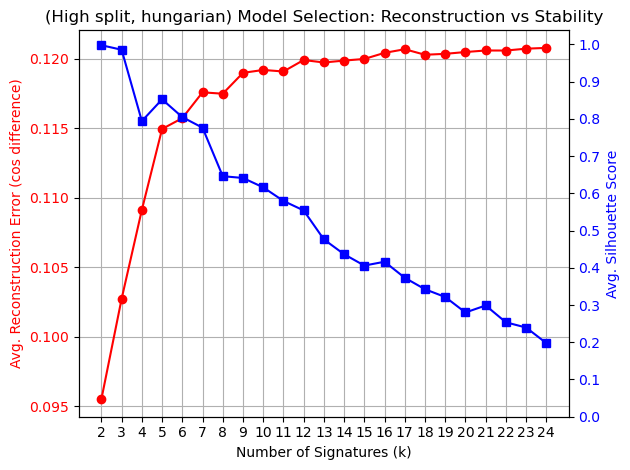

In [62]:
# VAR NAMES: S_high, A_high, M_star_high, recon_errors_high, stabilities_high

fig, ax1 = plt.subplots()

# Left y-axis: Reconstruction error
ax1.plot(ks, recon_errors_high, 'ro-', label='Reconstruction Error')  # red line with dots
ax1.set_xlabel("Number of Signatures (k)")
ax1.set_ylabel("Avg. Reconstruction Error (cos difference)", color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_xticks(ks)  # more x-axis ticks at each k
ax1.grid(True)

# Right y-axis: Silhouette score (stability)
ax2 = ax1.twinx()
ax2.plot(ks, stabilities_high, 'bs-', label='Silhouette Score')  # blue line with dots
ax2.set_ylabel("Avg. Silhouette Score", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_yticks(np.linspace(0, 1, 11))  # optional: more y ticks for stability axis

plt.title("(High split, hungarian) Model Selection: Reconstruction vs Stability")
fig.tight_layout()
plt.show()

#### LOW

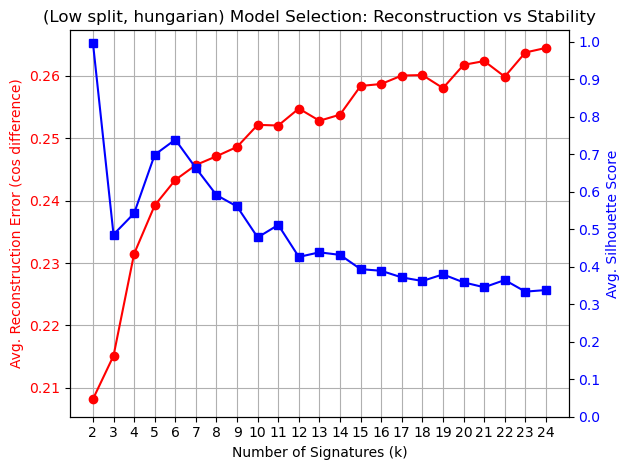

In [63]:
# VAR NAMES: S_low, A_low, M_star_low, recon_errors_low, stabilities_low

fig, ax1 = plt.subplots()

# Left y-axis: Reconstruction error
ax1.plot(ks, recon_errors_low, 'ro-', label='Reconstruction Error')  # red line with dots
ax1.set_xlabel("Number of Signatures (k)")
ax1.set_ylabel("Avg. Reconstruction Error (cos difference)", color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_xticks(ks)  # more x-axis ticks at each k
ax1.grid(True)

# Right y-axis: Silhouette score (stability)
ax2 = ax1.twinx()
ax2.plot(ks, stabilities_low, 'bs-', label='Silhouette Score')  # blue line with dots
ax2.set_ylabel("Avg. Silhouette Score", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_yticks(np.linspace(0, 1, 11))  # optional: more y ticks for stability axis

plt.title("(Low split, hungarian) Model Selection: Reconstruction vs Stability")
fig.tight_layout()
plt.show()

reconstruction error increases with # signatures, would expect opposite trend?

##### SigProfilerExtractor will consider solutions stable if the signatures derived in the solution have an average stability above 0.80 with no individual signature having stability below 0.20 (0.70 and 0.10, respectively, are the recommended thresholds for extractions based on whole-exome sequenced samples)

## Retry with k-medoid clustering. Note that this will take FOREVER

In [64]:
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.utils.metric import distance_metric, type_metric
from sklearn.preprocessing import normalize
import random

# Adjust these numbers when debugging for time's sake; reducing for k-medoid since intensive
n_runs = 50 # number of facorizations repeated for each k
nmf_iter = 1000 # maximum iterations for a given factorization

# Loop performing NMF for al values of K
ks = range(2, 10)

# Putting reconstruction & silhouette score calcuations in the clustering function this time
def kmedoid_clustering(S_list, M, distance_type='euclidean'):
    """
    Args:
        S_list: list of S matrices (mutation_types × k) from NMF replicates
        M: original data matrix (mutation_types × samples)
        distance_type: 'euclidean' or 'manhattan'
    
    Returns:
        S_consensus: consensus signature matrix (mutation_types × k)
        A_final: activity matrix (k × samples)
        recon_error: Frobenius norm of reconstruction error
        silhouette: silhouette score of clustering
    """
    k = S_list[0].shape[1]
    mutation_types = S_list[0].shape[0]

    # Stack all signature vectors from all replicates: shape = (num_replicates * k, mutation_types)
    S_stack = np.hstack(S_list).T  # shape = (num_replicates * k, mutation_types)

    # Initial medoid indices: pick k unique random indices
    initial_medoids = random.sample(range(S_stack.shape[0]), k)

    # Choose distance metric
    metric = distance_metric(type_metric.EUCLIDEAN)
    if distance_type == 'manhattan':
        metric = distance_metric(type_metric.MANHATTAN)

    # Run k-medoids clustering
    kmedoids_instance = kmedoids(data=S_stack.tolist(), initial_index_medoids=initial_medoids, metric=metric)
    kmedoids_instance.process()

    clusters = kmedoids_instance.get_clusters()
    medoid_indices = kmedoids_instance.get_medoids()
    labels = np.zeros(len(S_stack), dtype=int)
    for cluster_id, points in enumerate(clusters):
        labels[points] = cluster_id

    # Consensus S matrix from medoids
    S_consensus = S_stack[medoid_indices].T  # (mutation_types × k)

    # Solve for A using NNLS
    A_final = np.zeros((k, M.shape[1]))
    for i in range(M.shape[1]):
        A_final[:, i], _ = nnls(S_consensus, M[:, i])

    M_reconstructed = np.dot(S_consensus, A_final)
    #recon_error = np.linalg.norm(M - M_reconstructed, ord='fro')
    recon_error = np.mean(cosine_distances(M.T, M_reconstructed.T))

    # Silhouette score (for Euclidean/Manhattan only)
    silhouette = silhouette_score(S_stack, labels, metric=distance_type) if len(np.unique(labels)) > 1 else np.nan

    return S_consensus, A_final, M_reconstructed, recon_error, silhouette

def k_iteration_kmedoid(M,ks,n_runs,nmf_iter):
    # Tracking these metrics for each k
    avg_errors = []
    recon_errors = []
    stabilities = []
    
    # Store signatures for each k-value
    S_matrices = {}    # or S_list = []
    A_matrices = {}    # or A_list = []
    M_stars     = {}   # or M_star_list = []

    M_array = np.asarray(M)

    for k in tqdm(ks):
        S, A, loss = repeated_kl_nmf(M_array, k, n_runs, nmf_iter)
        avg_errors.append(np.mean(loss))
    
        # Do clustering with factorizations (S matrix only)
        S_consensus, A, M_star, recon_error, silhouette = kmedoid_clustering(S, M_array) 
    
        # Store values for plotting later
        recon_errors.append(recon_error)
        stabilities.append(silhouette)
    
        # Save S (centroids), A, M* for future use
        S_matrices[k] = S_consensus           # S = centroids, shape: [96 x k]
        A_matrices[k] = A                   # Activities, shape: [k x N]
        M_stars[k]     = M_star             # Reconstructed M*, shape: [96 x N]
    return S_matrices, A_matrices, M_stars, recon_errors, stabilities
    

#### HIGH

In [65]:
import os
# Because ARM architechture, comment out if using AMDx64 or just use scikit-learn-extra for k-medoid
os.environ['PYCLUSTERING_PACKAGE_ALLOW_CCORE'] = '0' 

S_high_kmedoid, A_high_kmedoid, M_stars_high_kmedoid, recon_errors_high_kmedoid, stabilities_high_kmedoid = k_iteration_kmedoid(M_high,ks,n_runs,nmf_iter)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [04:11<00:00, 31.48s/it]


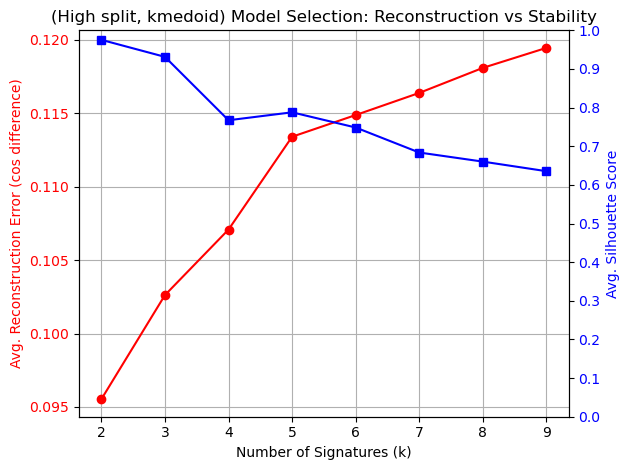

In [66]:

fig, ax1 = plt.subplots()

# Left y-axis: Reconstruction error
ax1.plot(ks, recon_errors_high_kmedoid, 'ro-', label='Reconstruction Error')  # red line with dots
ax1.set_xlabel("Number of Signatures (k)")
ax1.set_ylabel("Avg. Reconstruction Error (cos difference)", color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_xticks(ks)  # more x-axis ticks at each k
ax1.grid(True)

# Right y-axis: Silhouette score (stability)
ax2 = ax1.twinx()
ax2.plot(ks, stabilities_high_kmedoid, 'bs-', label='Silhouette Score')  # blue line with dots
ax2.set_ylabel("Avg. Silhouette Score", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_yticks(np.linspace(0, 1, 11))  # optional: more y ticks for stability axis

plt.title("(High split, kmedoid) Model Selection: Reconstruction vs Stability")
fig.tight_layout()
plt.show()

#### LOW

In [67]:
S_low_kmedoid, A_low_kmedoid, M_stars_low_kmedoid, recon_errors_low_kmedoid, stabilities_low_kmedoid = k_iteration_kmedoid(M_low,ks,n_runs,nmf_iter)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [04:22<00:00, 32.81s/it]


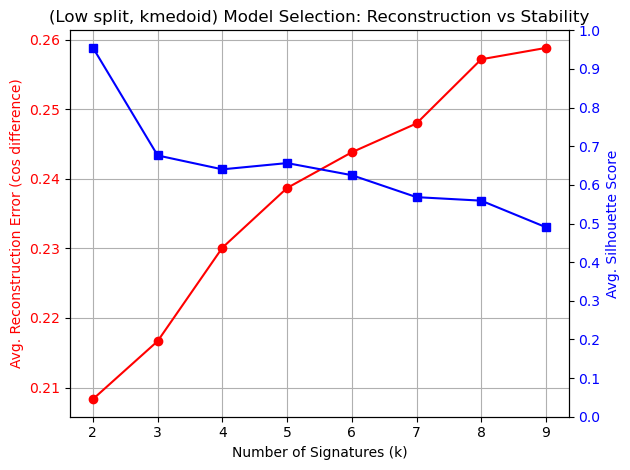

In [68]:

fig, ax1 = plt.subplots()

# Left y-axis: Reconstruction error
ax1.plot(ks, recon_errors_low_kmedoid, 'ro-', label='Reconstruction Error')  # red line with dots
ax1.set_xlabel("Number of Signatures (k)")
ax1.set_ylabel("Avg. Reconstruction Error (cos difference)", color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_xticks(ks)  # more x-axis ticks at each k
ax1.grid(True)

# Right y-axis: Silhouette score (stability)
ax2 = ax1.twinx()
ax2.plot(ks, stabilities_low_kmedoid, 'bs-', label='Silhouette Score')  # blue line with dots
ax2.set_ylabel("Avg. Silhouette Score", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_yticks(np.linspace(0, 1, 11))  # optional: more y ticks for stability axis

plt.title("(Low split, kmedoid) Model Selection: Reconstruction vs Stability")
fig.tight_layout()
plt.show()

## Run/Compare to SigProfilerExtractor
* Work in progress

In [ ]:
import sigProfilerExtractor

sigProfilerExtractor("matrix", out_put, M_high, reference_genome="GRCh37", opportunity_genome = "GRCh37", context_type = "default", exome = False, 
                         minimum_signatures=1, maximum_signatures=10, nmf_replicates=100, resample = True, batch_size=1, cpu=-1, gpu=False, 
                         nmf_init="random", precision= "single", matrix_normalization= "gmm", seeds= "random", 
                         min_nmf_iterations= 10000, max_nmf_iterations=1000000, nmf_test_conv= 10000, nmf_tolerance= 1e-15, get_all_signature_matrices= False)

### Compare M and M* and distributions of SBS-96 types

## Metadata matching
### Choose an appropriate k-value for either clustering method and both splits (use plots)
* To get **order of SNP96**: M_low.index
* To get Matrices and cluster labels, re-run here for the desired k-value:

### LOW

In [133]:
k = 6 # silhouette score is not above 0.8 but I wouldn't want to use a lower k-value?

n_runs = 100 # number of times facortization is repeated for each k
nmf_iter = 1000 # maximum iterations for a given factorization
hungarian_iter = 100

S_list_low, A_list_low, loss_list_low = repeated_kl_nmf(M_low, k, n_runs, nmf_iter)
S_low, stability_low, cluster_labels_low = hungarian_clustering(S_list_low, k, hungarian_iter, tol=1e-4)
A_low = solve_activities(np.asarray(M_low), S_low)

### HIGH

In [134]:
k = 3 # Maybe 3 or 4?

S_list_high, A_list_high, loss_list_high = repeated_kl_nmf(M_high, k, n_runs, nmf_iter)
S_high, stability_high, cluster_labels_high = hungarian_clustering(S_list_high, k, hungarian_iter, tol=1e-4)
A_high = solve_activities(np.asarray(M_high), S_high)

## Some Plots

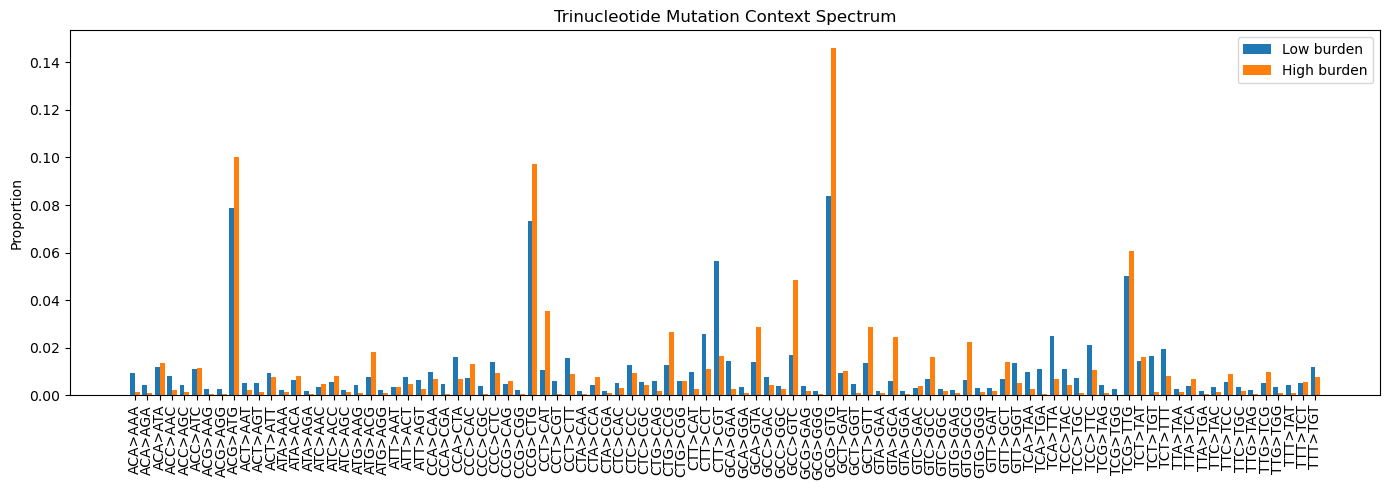

In [135]:
low_sum = low_matrix.reindex(columns=all_contexts, fill_value=0).sum(axis=0)
high_sum = high_matrix.reindex(columns=all_contexts, fill_value=0).sum(axis=0)

# Normalize
low_norm = low_sum / low_sum.sum()
high_norm = high_sum / high_sum.sum()

# Plot
fig, ax = plt.subplots(figsize=(14, 5))
width = 0.4
x = np.arange(len(all_contexts))

ax.bar(x - width/2, low_norm.values, width=width, label='Low burden')
ax.bar(x + width/2, high_norm.values, width=width, label='High burden')

ax.set_xticks(x)
ax.set_xticklabels(all_contexts, rotation=90)
ax.set_ylabel("Proportion")
ax.set_title("Trinucleotide Mutation Context Spectrum")
ax.legend()
plt.tight_layout()
plt.show()

### HIGH

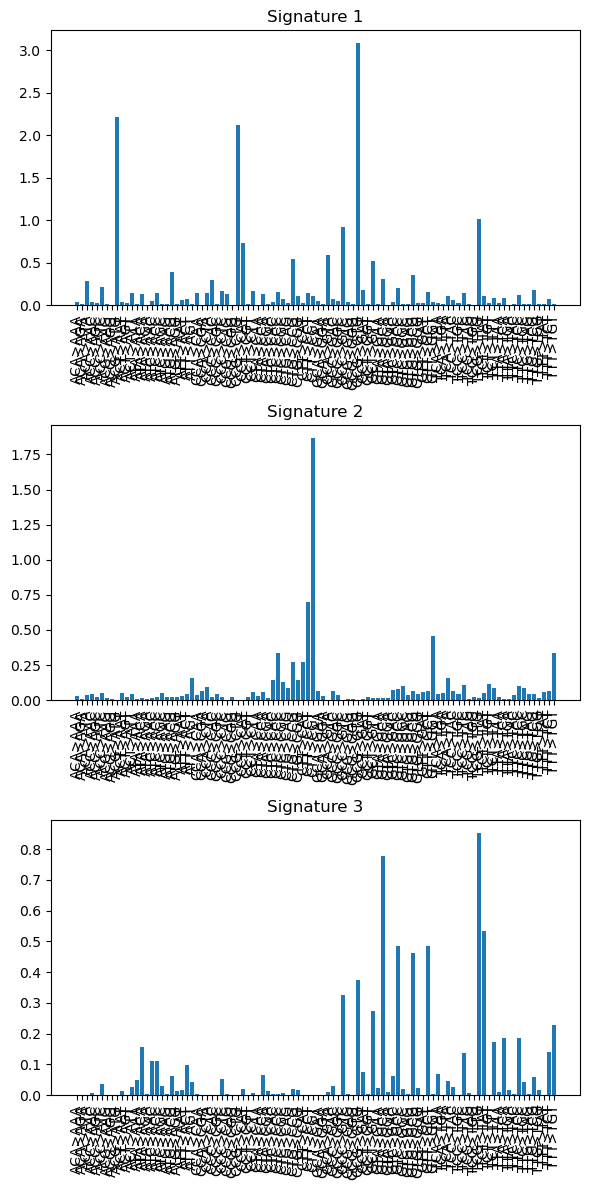

In [138]:
# S_high_plot = S_high.T
# plt.figure(figsize=(18, 4))
# for i, row in enumerate(S_high_plot):
#     plt.subplot(1, S_high_plot.shape[0], i + 1)
#     plt.bar(range(len(row)), row)
#     plt.title(f'Signature {i+1}')
#     plt.xticks(range(len(row)), M_low.index, rotation=90)
#     plt.tight_layout()


# Stack vertically for viewability
S_high_plot = S_high.T
plt.figure(figsize=(6, 4 * S_high_plot.shape[0]))  # Adjust height dynamically
for i, row in enumerate(S_high_plot):
    plt.subplot(S_high_plot.shape[0], 1, i + 1)  # vertical stack: (rows, cols, index)
    plt.bar(range(len(row)), row)
    plt.title(f'Signature {i+1}')
    plt.xticks(range(len(row)), M_low.index, rotation=90)
plt.tight_layout()


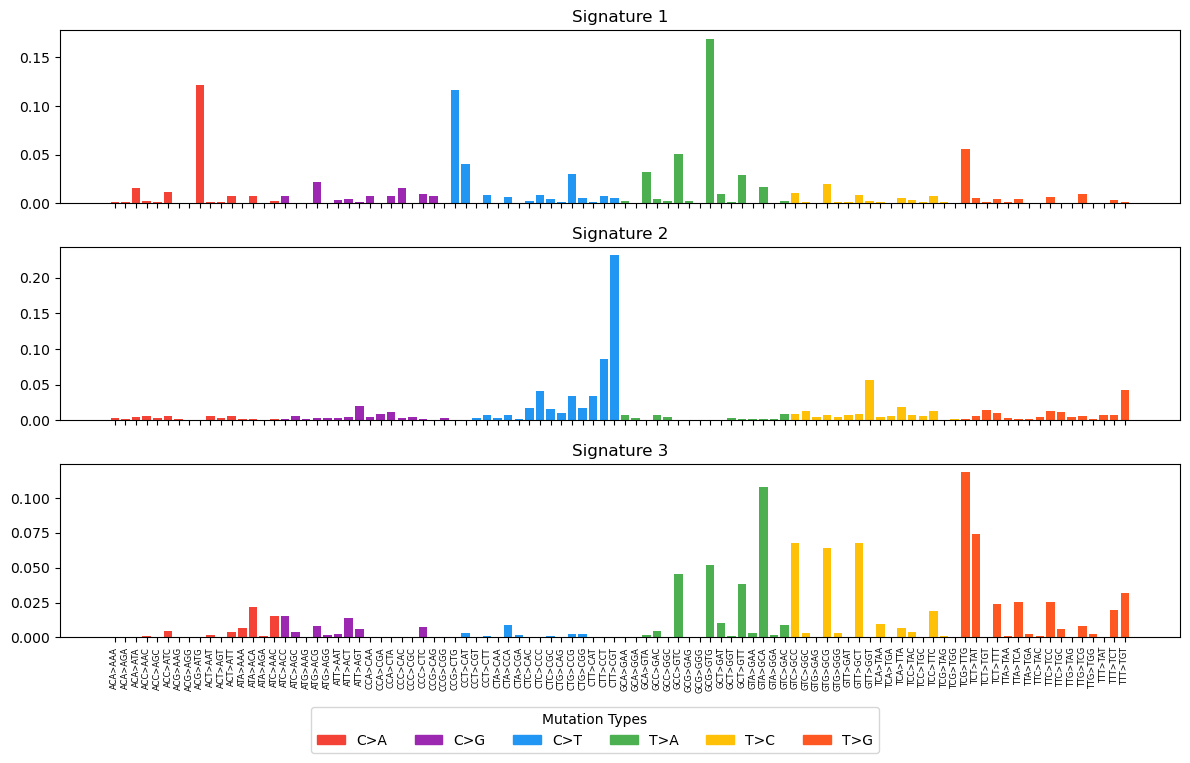

In [148]:
from matplotlib.patches import Patch

filtered_contexts = M_high.index
filtered_contexts_list = filtered_contexts
mut_type = [context[1] + context[3] + context[5] for context in filtered_contexts]
context_mut_df = pd.DataFrame({
    'context': filtered_contexts_list,
    'mut_type': mut_type
})

context_mut_df['context'] = context_mut_df['context'].astype(str)
context_mut_df.sort_values(by=['mut_type', 'context'], ascending=True, inplace=True)

sorted_filtered_contexts = context_mut_df['context'].tolist()
sorted_mut_type = context_mut_df['mut_type'].tolist()


mutation_colors = {
    'C>A': '#F44336',  # Red
    'C>G': '#9C27B0',  # Purple
    'C>T': '#2196F3',  # Blue
    'T>A': '#4CAF50',  # Green
    'T>C': '#FFC107',  # Amber
    'T>G': '#FF5722'   # Deep Orange
}

#colors = [mutation_colors.get(mut, '#000000') for mut in mut_type] 
colors = [mutation_colors.get(mut, '#000000') for mut in sorted_mut_type]
H_normalized = S_high_plot / S_high_plot.sum(axis=1)[:, np.newaxis]
#cluster_labels = np.argmax(H_normalized, axis=0)

#silhouette_avg = silhouette_score(data, cluster_labels)

from matplotlib import colors as mcolors
from matplotlib.colorbar import ColorbarBase

mutation_cmap = mcolors.ListedColormap(list(mutation_colors.values()))

num_rows = int(np.sqrt(S_high_plot.shape[0])) + 1
num_cols = int(np.ceil(S_high_plot.shape[0] / num_rows))

num_sigs = H_normalized.shape[0]
fig, axes = plt.subplots(nrows=num_sigs, ncols=1, figsize=(12, 2.5 * num_sigs), sharex=True)

for i, (row, ax) in enumerate(zip(H_normalized, axes)):
    ax.bar(range(len(row)), row, color=colors)
    ax.set_title(f'Signature {i + 1}', fontsize=12)
    ax.set_xticks(range(len(row)))
    ax.set_xticklabels(M_high.index, rotation=90, fontsize=6)

# Legend: move it to the bottom outside the plot
handles = [Patch(color=color, label=label) for label, color in mutation_colors.items()]
fig.legend(handles=handles,
           loc='lower center',
           bbox_to_anchor=(0.5, -0.02),
           ncol=len(handles),
           title="Mutation Types",
           fontsize=10)

plt.tight_layout(rect=[0, 0.05, 1, 1])  # Leave space for legend
plt.show()


# for i, row in enumerate(H_normalized):
    
#     plt.subplot(num_rows, num_cols, i + 1)
#     #plt.bar(range(len(row)), row)
#     plt.bar(range(len(row)), row, color=colors)
#     plt.title(f'Signature {i + 1}')
#     plt.xticks(range(len(row)), M_high.index, rotation=90)
#     #plt.xticks(range(len(row)), filtered_contexts, rotation=90)

# plt.legend(
#     handles=[Patch(color=color, label=label) for label, color in mutation_colors.items()],
#     loc='lower right', bbox_to_anchor=(2, 0), title="Mutation Types", fontsize=10
# )

# plt.tight_layout()
# plt.show()

### LOW

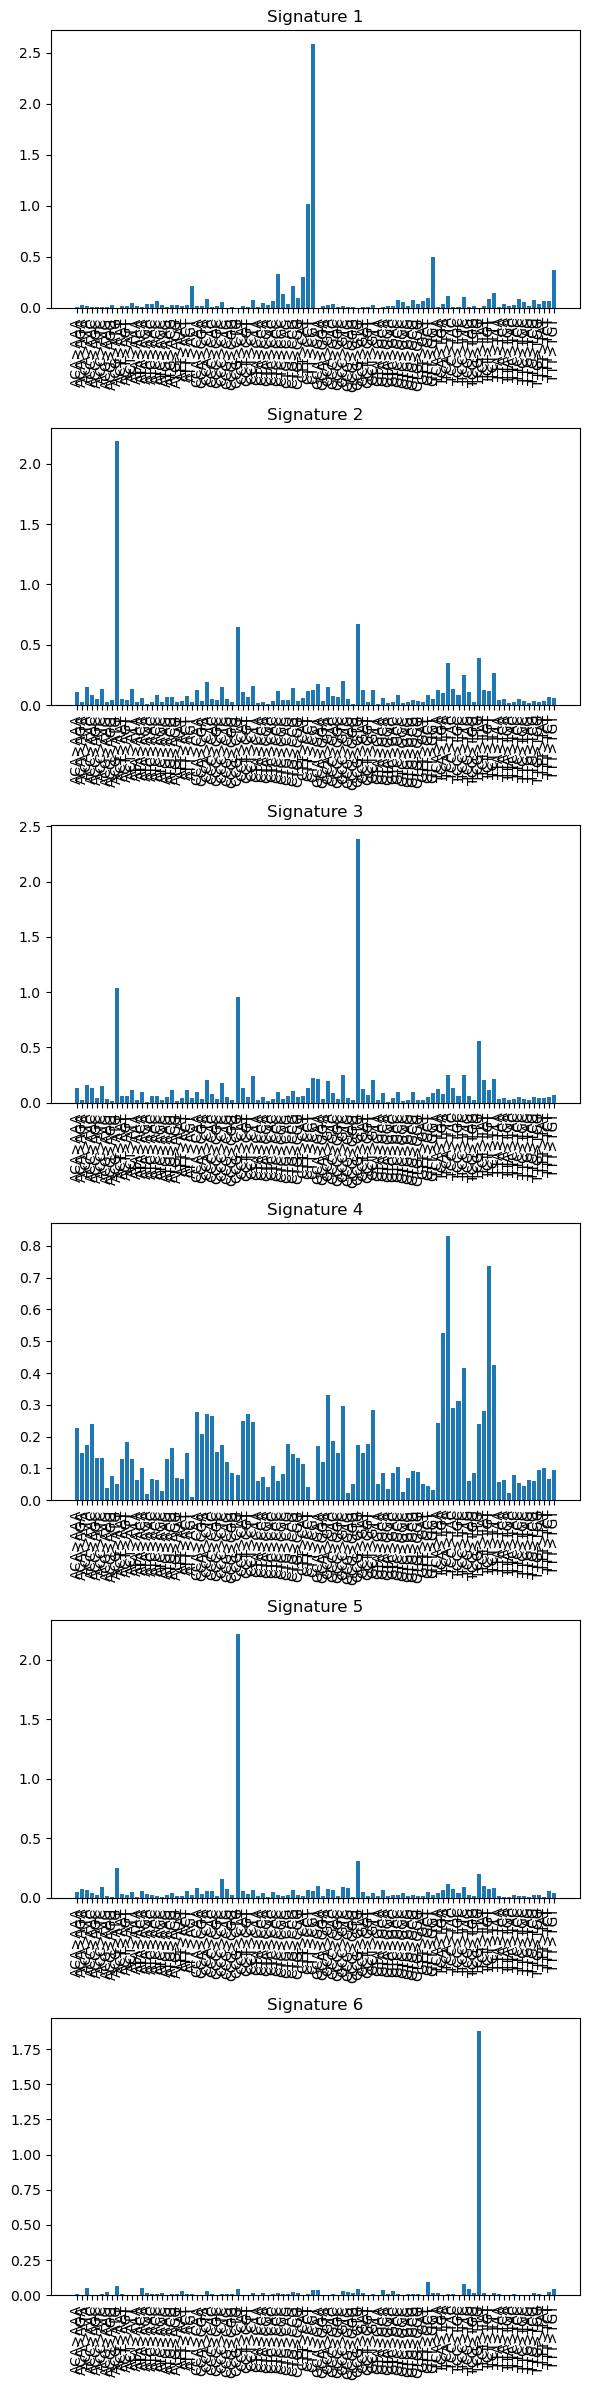

In [139]:
# S_low_plot = S_low.T
# plt.figure(figsize=(18, 4))
# for i, row in enumerate(S_low_plot):
#     plt.subplot(1, S_low_plot.shape[0], i + 1)
#     plt.bar(range(len(row)), row)
#     plt.title(f'Signature {i+1}')
#     plt.xticks(range(len(row)), M_low.index, rotation=90)
#     plt.tight_layout()

# Vertical for viewing
S_low_plot = S_low.T
plt.figure(figsize=(6, 4 * S_low_plot.shape[0]))  # Adjust height dynamically
for i, row in enumerate(S_low_plot):
    plt.subplot(S_low_plot.shape[0], 1, i + 1)  # vertical stack
    plt.bar(range(len(row)), row)
    plt.title(f'Signature {i+1}')
    plt.xticks(range(len(row)), M_low.index, rotation=90)
plt.tight_layout()

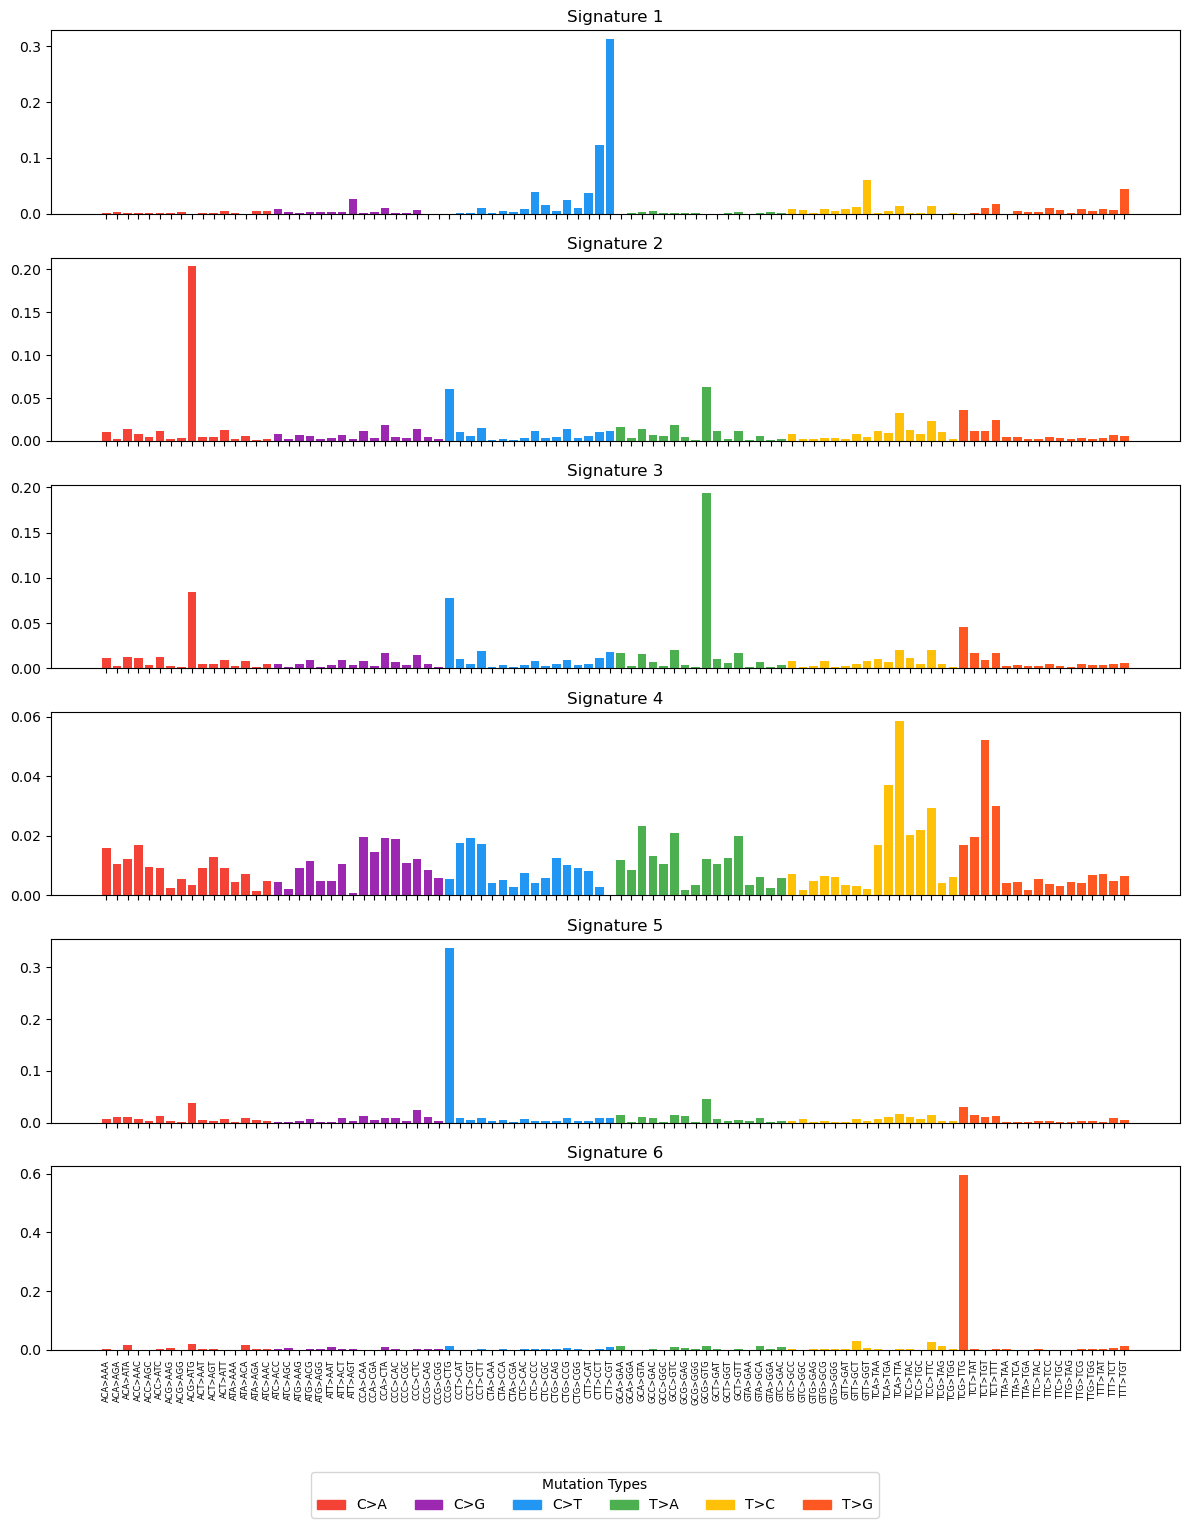

In [147]:
filtered_contexts = M_low.index
filtered_contexts_list = filtered_contexts
mut_type = [context[1] + context[3] + context[5] for context in filtered_contexts]
context_mut_df = pd.DataFrame({
    'context': filtered_contexts_list,
    'mut_type': mut_type
})

context_mut_df['context'] = context_mut_df['context'].astype(str)
context_mut_df.sort_values(by=['mut_type', 'context'], ascending=True, inplace=True)

sorted_filtered_contexts = context_mut_df['context'].tolist()
sorted_mut_type = context_mut_df['mut_type'].tolist()


mutation_colors = {
    'C>A': '#F44336',  # Red
    'C>G': '#9C27B0',  # Purple
    'C>T': '#2196F3',  # Blue
    'T>A': '#4CAF50',  # Green
    'T>C': '#FFC107',  # Amber
    'T>G': '#FF5722'   # Deep Orange
}

#colors = [mutation_colors.get(mut, '#000000') for mut in mut_type] 
colors = [mutation_colors.get(mut, '#000000') for mut in sorted_mut_type]
H_normalized = S_low_plot / S_low_plot.sum(axis=1)[:, np.newaxis]
#cluster_labels = np.argmax(H_normalized, axis=0)

#silhouette_avg = silhouette_score(data, cluster_labels)

from matplotlib import colors as mcolors
from matplotlib.colorbar import ColorbarBase

mutation_cmap = mcolors.ListedColormap(list(mutation_colors.values()))

num_rows = int(np.sqrt(S_low_plot.shape[0])) + 1
num_cols = int(np.ceil(S_low_plot.shape[0] / num_rows))

num_sigs = H_normalized.shape[0]
fig, axes = plt.subplots(nrows=num_sigs, ncols=1, figsize=(12, 2.5 * num_sigs), sharex=True)

for i, (row, ax) in enumerate(zip(H_normalized, axes)):
    ax.bar(range(len(row)), row, color=colors)
    ax.set_title(f'Signature {i + 1}', fontsize=12)
    ax.set_xticks(range(len(row)))
    ax.set_xticklabels(M_low.index, rotation=90, fontsize=6)

# Legend: move it to the bottom outside the plot
handles = [Patch(color=color, label=label) for label, color in mutation_colors.items()]
fig.legend(handles=handles,
           loc='lower center',
           bbox_to_anchor=(0.5, -0.02),
           ncol=len(handles),
           title="Mutation Types",
           fontsize=10)

plt.tight_layout(rect=[0, 0.05, 1, 1])  # Leave space for legend
plt.show()

# for i, row in enumerate(H_normalized):
    
#     plt.subplot(num_rows, num_cols, i + 1)
#     #plt.bar(range(len(row)), row)
#     plt.bar(range(len(row)), row, color=colors)
#     plt.title(f'Signature {i + 1}')
#     plt.xticks(range(len(row)), M_low.index, rotation=90)
#     #plt.xticks(range(len(row)), filtered_contexts, rotation=90)

# plt.legend(
#     handles=[Patch(color=color, label=label) for label, color in mutation_colors.items()],
#     loc='lower right', bbox_to_anchor=(2, 0), title="Mutation Types", fontsize=10
# )

# plt.tight_layout()
# plt.show()